In [1]:
import json
import numpy as np
from os import walk
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('gallery.json') as json_file:
    data = json.load(json_file)
    print(len(data))
    print(data[0])

13115
[2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2]


## Helpers to get train/test images/labels

In [3]:
def get_train_test_labels():
    train_labels = dict()
    test_labels = dict()

    with open('market_attribute.json') as json_file:
        data = json.load(json_file)
        train = data['train']
        test = data['test']

        for i, image_index in enumerate(train['image_index']):
            img_labels = []
            for key in train.keys():
                if key != 'image_index':
                    img_labels.append(train[key][i])
            train_labels[image_index] = np.array(img_labels)
            
        for i, image_index in enumerate(test['image_index']):
            img_labels = []
            for key in train.keys():
                if key != 'image_index':
                    img_labels.append(test[key][i])
            test_labels[image_index] = np.array(img_labels)
            
    return train_labels, test_labels

In [4]:
def get_train_test_images():
    files = []
    for (dirpath, dirnames, filenames) in walk("./Market-1501"):
        files.extend(filenames)
        break
        
    print('number of images:', len(files))
    
    files.sort()
    
        
    train_images = []
    test_images = []
    with open('market_attribute.json') as json_file:
        data = json.load(json_file)
        train_indexes = data['train']['image_index']
        test_indexes = data['test']['image_index']
        for i, file in enumerate(files):
            if file[:4] in train_indexes:
                train_images.append(file)
            elif file[:4] in test_indexes:
                test_images.append(file)
                
    return (train_images, test_images)
    

In [5]:
import numpy as np
from keras.utils import Sequence
from keras_preprocessing import image
from keras.applications.resnet50 import preprocess_input
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image

class ImageGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=10, shuffle=True):

        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def augment(self, images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            iaa.ContrastNormalization((0.75, 1.5)),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-10, 10),
                shear=(-8, 8)
            )
        ], random_order=True) # apply augmenters in random order

        images_aug = seq(images=images)
        
        return images_aug

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, * self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, image_path in enumerate(list_IDs_temp):
            img = image.load_img("Market-1501/" + image_path, target_size=(224, 224, 3))
            
            img_array = image.img_to_array(img)
            
            if np.random.choice([0,1]) == 0:
                print("augment")
                img_array = self.augment([img_array])[0]
            
            img_array = preprocess_input(img_array)
            img_index = image_path[:4]
            labels = np.delete(self.labels[img_index], 0) - 1
            
            X[i, ] = img_array
            y[i, ] = labels
                    
        return X, y

Using TensorFlow backend.


In [6]:
train_images, test_images = get_train_test_images()
train_labels, test_labels = get_train_test_labels()

number of images: 25260


## Images attributes proportions analysis

In [10]:
def get_proportions(labels, indexes):

    files = []
    for (dirpath, dirnames, filenames) in walk("./Market-1501"):
        files.extend(filenames)
        break

    print('number of images:', len(files))

    files.sort()
    image_rep = dict()

    for i, file in enumerate(files):
        if file[:4] in indexes:
            image_rep[file[:4]] = image_rep.get(file[:4], 0) + 1

    real_attributes = dict()
    for key in labels.keys():
        if key != "image_index":
            for attr_val, index in zip(labels[key], indexes):
                attrs = real_attributes.get(key, [])
                attrs.extend(attr_val for x in range(image_rep[index]))
                real_attributes[key] = attrs

    up_color = {
        'upblack': real_attributes['upblack'], 
        'upwhite': real_attributes['upwhite'], 
        'upred': real_attributes['upred'], 
        'uppurple': real_attributes['uppurple'], 
        'upyellow': real_attributes['upyellow'], 
        'upgray': real_attributes['upgray'],
        'upblue': real_attributes['upblue'],
        'upgreen': real_attributes['upgreen']  
    }

    down_color = {
        'downblack': real_attributes['downblack'], 
        'downwhite': real_attributes['downwhite'], 
        'downpink': real_attributes['downpink'], 
        'downpurple': real_attributes['downpurple'], 
        'downyellow': real_attributes['downyellow'], 
        'downgray': real_attributes['downgray'], 
        'downblue': real_attributes['downblue'],
        'downgreen': real_attributes['downgreen'],
        'downbrown': real_attributes['downbrown']
    }

    df_up = pd.DataFrame(data=up_color).idxmax(1)
    df_down = pd.DataFrame(data=down_color).idxmax(1)
    
    return real_attributes, df_up, df_down

In [11]:
with open('market_attribute.json') as json_file:
    data = json.load(json_file)
    
    train_labels = data['train']
    test_labels = data['test']
    
    train_indexes = train_labels['image_index']
    test_indexes = test_labels['image_index']
    
    all_indexes = np.concatenate((train_indexes, test_indexes), axis=None)
    all_indexes.sort()
    
    all_labels = dict()
    all_labels = train_labels
    for key, value in test_labels.items():
        all_labels[key] = value

real_attributes, df_up, df_down = get_proportions(test_labels, test_indexes)

number of images: 25260


In [12]:
def plot_color_hist(values, labels):
    bins = np.arange(len(values))

    width = 0.7 * (bins[1] - bins[0])
    center = np.arange(len(values))

    ax = plt.subplot(111)

    ax.bar(center, values, align='center', width=width)
    plt.xticks(bins, labels)
    plt.title('colors')
    plt.show()

In [13]:
def plot_attr_hist(title, attribute_vals):
    bins = np.arange(len(attribute_vals))
    
    unique, counts = np.unique(attribute_vals, return_counts=True)
    width = 0.7 * (bins[1] - bins[0])
    center = unique
    plt.bar(center, counts, align='center', width=width)
    plt.title(title)
    plt.show()

In [14]:
unique, counts = np.unique(real_attributes['handbag'], return_counts=True)
for i in counts:
    print(i * 100 / np.sum(counts))

90.45067759218405
9.549322407815946


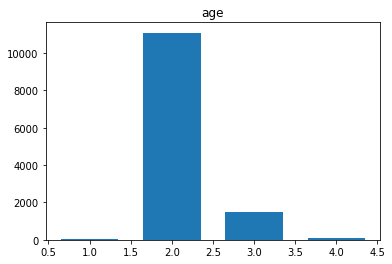

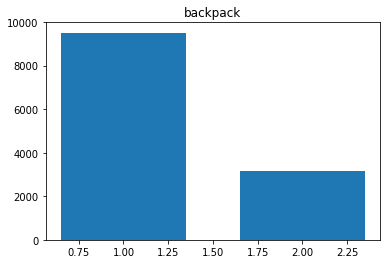

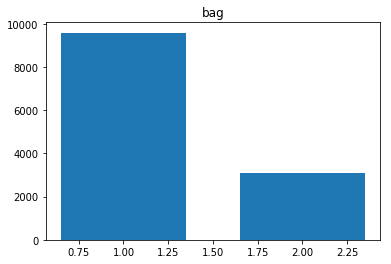

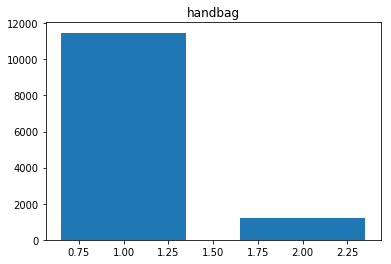

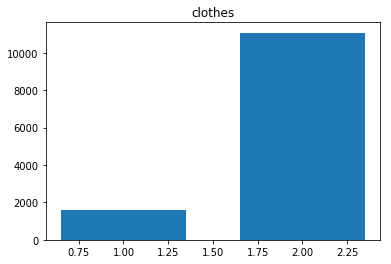

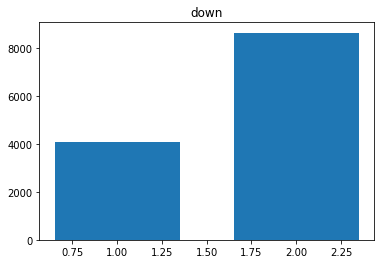

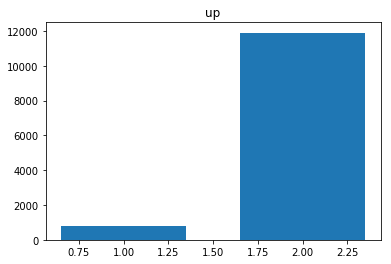

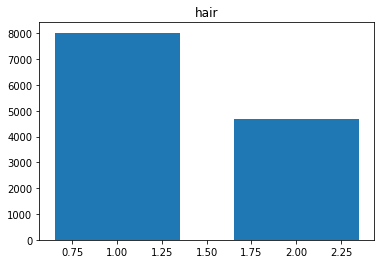

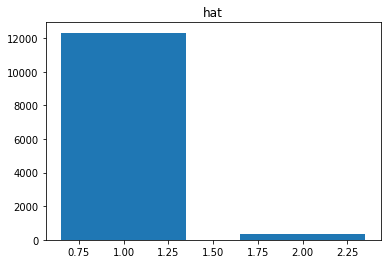

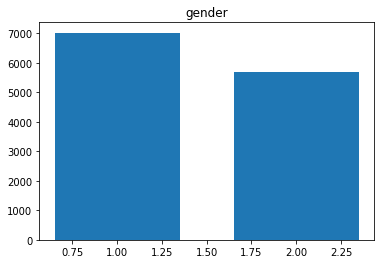

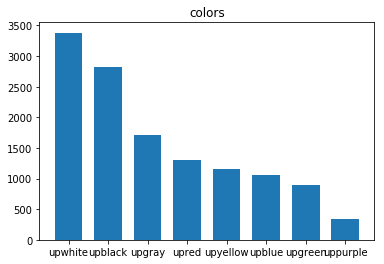

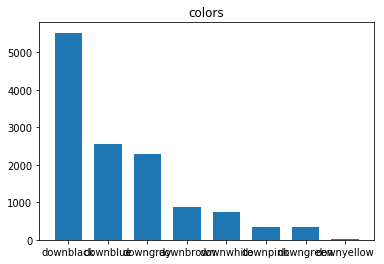

In [15]:
plot_attr_hist('age', real_attributes['age'])
plot_attr_hist('backpack',real_attributes['backpack'])
plot_attr_hist('bag',real_attributes['bag'])
plot_attr_hist('handbag',real_attributes['handbag'])
plot_attr_hist('clothes',real_attributes['clothes'])
plot_attr_hist('down',real_attributes['down'])
plot_attr_hist('up',real_attributes['up'])
plot_attr_hist('hair',real_attributes['hair'])
plot_attr_hist('hat',real_attributes['hat'])
plot_attr_hist('gender',real_attributes['gender'])

plot_color_hist(df_up.value_counts().values, df_up.value_counts().index.values)
plot_color_hist(df_down.value_counts().values, df_down.value_counts().index.values)

In [8]:
df_up.value_counts()

upwhite     3382
upblack     2829
upgray      1719
upred       1308
upyellow    1155
upblue      1053
upgreen      903
uppurple     343
dtype: int64